In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns;sns.set_style("dark") # remove gridline

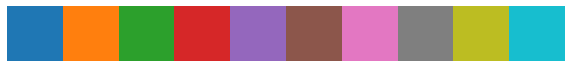

In [2]:
palette = sns.color_palette()
sns.palplot(palette)

# Theoretical estimation

In [3]:
# calculating data
dx = np.linspace(25, 400)
dz = np.linspace(0.02, 0.6)
A = 1
B = 1000
D = 2*A*dx[np.newaxis,:]+B*dz[:,np.newaxis]
D = D/D.max()

In [4]:
D.min(), D.max()

(0.050000000000000003, 1.0)

In [5]:
# convenience plotting functions

color1 = palette[3] # choose line color
color2 = 'white'

def add_scaling_line(ax, dx):
    '''optimal scaling lines'''
    ax.plot(dx, dx/1500, '--', color = color1, label='$\Delta x/\Delta z = 1500$')
    ax.plot(dx, dx/1000, '--', color = color2, label='$\Delta x/\Delta z = 1000$')
    
def add_legend(ax):
    '''set legend box color
    https://stackoverflow.com/questions/19863368/matplotlib-legend-background-color
    '''
    legend = ax.legend(loc=1, fontsize=13, frameon=1)
    frame = legend.get_frame()
    frame.set_edgecolor('black')
    frame.set_facecolor('w')
    frame.set_alpha(0.5)
    
def add_constraint(ax, dx):

    # dx^3*dx = P, computational resource constraint
    dzz = 0.3e6/dx**3
    for i, level in enumerate([1/32, 1/4, 2, 16]):
        label = '$\Delta z \cdot \Delta x^3=const$' if i==0 else None
        ax.plot(dx, level*dzz, c=color1, label=label)

    # dx^2*dx = P, box number constaint
    dzz = 0.15e4/dx**2
    for i, level in enumerate([1/16, 1/4, 1, 4, 16]):
        label = '$\Delta z \cdot \Delta x^2=const$' if i==0 else None
        ax.plot(dx, level*dzz, c=color2, label=label)
        

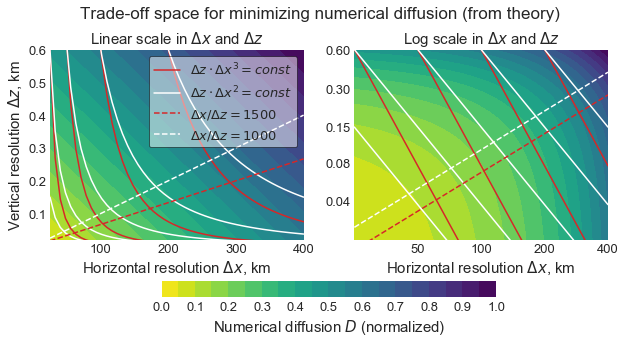

In [6]:
fig, axes = plt.subplots(1, 2, figsize=[10, 5])

titlesize = 15

# == linear scale ==
ax = axes[0]
ax.set_title('Linear scale in $\Delta x$ and $\Delta z$', fontsize=titlesize)

def add_contour(ax, dx, dz, D):
    im = ax.contourf(dx, dz, D, 
                 levels=np.linspace(0, D.max(), 21),
                 cmap='viridis_r')
    ax.set_xlim([dx.min(),dx.max()])
    ax.set_ylim([dz.min(),dz.max()]) 
    
    # make label fonts larger
    ax.xaxis.set_tick_params(labelsize=13)
    ax.yaxis.set_tick_params(labelsize=13)
    return im

ax.set_xlabel('Horizontal resolution $\Delta x$, km', fontsize=15)
ax.set_ylabel('Vertical resolution $\Delta z$, km', fontsize=15)

im = add_contour(ax, dx, dz, D)
add_constraint(ax, dx)
add_scaling_line(ax, dx)

add_legend(ax)

# == log scale ==
ax = axes[1]
ax.set_title('Log scale in $\Delta x$ and $\Delta z$', fontsize=titlesize)

add_contour(ax, dx, dz, D)

ax.set_xlabel('Horizontal resolution $\Delta x$, km', fontsize=15)

add_constraint(ax, dx)
add_scaling_line(ax, dx)

# switch to log scale
ax.set_xscale('log');ax.set_yscale('log')

# fix tick labels
# https://stackoverflow.com/questions/21920233/matplotlib-log-scale-tick-label-number-formatting
from matplotlib.ticker import ScalarFormatter
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())
ax.set_yticks([0.04, 0.08, 0.15, 0.3 , 0.6])
ax.set_xticks([50, 100, 200, 400])

# == common colorbar ===
cb = fig.colorbar(im, ax=axes.tolist(), shrink=0.6,
                  orientation='horizontal',
                  ticks=np.linspace(0, D.max(), 11))
cb.set_label('Numerical diffusion $D$ (normalized)', fontsize=15)
cb.ax.tick_params(labelsize=13)
 
# === common title ===
fig.suptitle('Trade-off space for minimizing numerical diffusion (from theory)', 
             fontsize = titlesize+2, y = 1.00)

fig.savefig('scaling_theory.png', dpi=300)


# Numerical experiment

In [7]:
# Basic parameters

Vres_list = [20,40,80,160]
Hres_list = [48,96,192,384]

dx_list = 200/np.array([1,2,4,8])
dz_list = 0.6/np.array([1,2,4,8])
dx_list

array([ 200.,  100.,   50.,   25.])

In [8]:
Vlabels = ['L{0}'.format(r) for r in Vres_list]
Hlabels = ['C{0}'.format(r) for r in Hres_list]
Vlabels, Vlabels

(['L20', 'L40', 'L80', 'L160'], ['L20', 'L40', 'L80', 'L160'])

## read simulation results

### Max VMR data

In [9]:
import FV3log
maindir = "/Users/zhuangjw/Research/Computing/FV3/outputlog/"
ds = FV3log.extract_HsVs(maindir, ['plume01'], Hres_list, Vres_list)
ds


 open: C48L20_std.log C48L40_std.log C48L80_std.log C48L160_std.log 
 open: C96L20_std.log C96L40_std.log C96L80_std.log C96L160_std.log 
 open: C192L20_std.log C192L40_std.log C192L80_std.log C192L160_std.log 
 open: C384L20_std.log C384L40_std.log C384L80_std.log C384L160_std.log 

<xarray.Dataset>
Dimensions:  (Hres: 4, Vres: 4, time: 9)
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8
  * Vres     (Vres) int64 20 40 80 160
  * Hres     (Hres) int64 48 96 192 384
Data variables:
    plume01  (Hres, Vres, time) float32 1.0 0.884535 0.541212 0.319658 ...

In [10]:
dr_VMR = ds['plume01'].isel(time=-1)
dr_VMR.to_pandas()

Vres,20,40,80,160
Hres,,,,
48,0.093736,0.097327,0.113596,0.117215
96,0.071262,0.118098,0.152428,0.164323
192,0.110981,0.200145,0.310812,0.364484
384,0.128934,0.242495,0.435029,0.660734


### Entropy data

In [11]:
import xarray as xr
maindir = "../small_output/"
dr_En = xr.open_dataarray(maindir+'plume01_entropy_all.nc',decode_times=False)
dr_En = dr_En.isel(time=-1)/dr_En.isel(time=0) # last day normalize by initial condition
dr_En.to_pandas()

Vres,20,40,80,160
Hres,,,,
48,20.172739,19.482781,19.252269,19.242033
96,19.358296,17.900697,17.251867,17.098004
192,18.398357,16.489271,15.217000,14.744221
384,17.920005,15.454721,13.668386,12.989346


## Plotting

In [12]:
# convenience plotting functions

def log_switch(ax, is_ylabel = True):
    '''switch to log scale'''
    ax.set_xscale('log')
    ax.set_yscale('log')

    # make label fonts larger
    ax.xaxis.set_tick_params(labelsize=13)
    ax.yaxis.set_tick_params(labelsize=13)
    ax.set_xlabel('Horizontal resolution $\Delta x$, km', fontsize=15)
    
    # fix ticks
    ax.minorticks_off()
    
    ax.set_xticks(dx_list)
    ax.set_xticklabels(['200\n(C48)', 
                        '100\n(C96)',
                        '50\n(C192)',
                        '25\n(C384)']) 
    
    if is_ylabel:
        ax.set_yticks(dz_list)
        ax.set_yticklabels(['0.6\n(L20)', 
                            '0.3\n(L40)',
                            '0.15\n(L80)',
                            '0.075\n(L160)'])
        ax.set_ylabel('Vertical resolution $\Delta z$, km', fontsize=15)
    else:
        ax.set_yticks([])
        ax.set_yticklabels([]) 
    
def add_data(ax):
    '''overlay data points'''
    xxs, yys = np.meshgrid(dx_list,dz_list)
    dot_color = (0.7686274509803922, 0.30588235294117649, 0.32156862745098042)
    ax.scatter(xxs, yys, color=dot_color)
    ax.set_xlim([24.5,205])
    ax.set_ylim([0.6/8*0.96, 0.62])
    #ax.set_ylim([0.6/16*0.96, 0.62]) # extrapolation

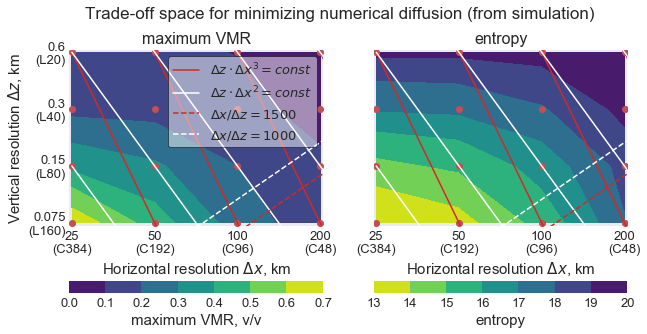

In [13]:
fig, axes = plt.subplots(1, 2, figsize=[10, 5])

# == max VMR plot ==
ax = axes[0]

log_switch(ax)
    
# make filled-contour plot
im = ax.contourf(dx_list, dz_list, dr_VMR.values,
                 levels = np.linspace(0, 0.7, 8),
                 cmap='viridis')

ax.set_title('maximum VMR', fontsize=16)

cb = fig.colorbar(im, ax=ax, orientation='horizontal', pad=0.2)
cb.set_label('maximum VMR, v/v', fontsize=15)
cb.ax.tick_params(labelsize=13) 

add_data(ax)
add_constraint(ax, dx)
add_scaling_line(ax, dx)

add_legend(ax)

# == entropy plot ==
ax = axes[1]

log_switch(ax, is_ylabel=False)

dr_En = np.clip(dr_En,13,20) # fix tiny missing region
im = ax.contourf(dx_list, dz_list, dr_En.values, cmap='viridis_r',
                 levels = np.linspace(13, 20, 8))
ax.set_title('entropy', fontsize=16)

cb = fig.colorbar(im, ax=ax, orientation='horizontal', pad=0.2)
cb.set_label('entropy', fontsize=15)
cb.ax.tick_params(labelsize=13) 

add_data(ax)
add_constraint(ax, dx)
add_scaling_line(ax, dx)

fig.suptitle('Trade-off space for minimizing numerical diffusion (from simulation)', 
             fontsize = titlesize+2, y = 1.00)

#fig.tight_layout()
fig.savefig('scaling_simulation.png', dpi=300)